In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
# import seaborn as sns
pd.set_option('display.max_rows', 250)

In [147]:
# %%time
!cd ..;python parse_tb.py

### wikitext - multiseg

In [148]:
res_df = pd.read_csv('../results/wikitext.csv')
res_df = res_df[res_df.task_name == 'wikitext-2-v1']

In [149]:
res_df.num_mem_tokens = res_df.num_mem_tokens.fillna('NA')
res_df.max_n_segments = res_df.max_n_segments.fillna('NA')
# df.share_memory_layers = df.share_memory_layers.fillna(False)
res_df.k2 = res_df.k2.fillna(-1)
# res_df['checkpoint_segment'] = res_df.model_path.apply(lambda x: x.split('from_cpt_')[1].split('-')[0] if 'from_cpt_' in x else -1).astype(int)
# res_df['eval_segment'] = res_df.max_n_segments
# df['from_cpt'] = (~df.backbone_cpt.isna()).fillna(False)
# df.freeze_model_weights = df.freeze_model_weights.fillna(False)
res_df['init_from'] = False
res_df.loc[~res_df['model_cpt'].isna(), 'init_from'] = 'RMT'
res_df.loc[~res_df['backbone_cpt'].isna(), 'init_from'] = 'baseline'

res_df['lora'] = res_df.model_path.apply(lambda x: 'lora' in x)


In [150]:
def get_cpt_segment(model_path):
    if 'from_cpt_' not  in model_path:
        return -1
    
    sep = "from_cpt_full_" if "from_cpt_full_" in model_path else "from_cpt_"
    return model_path.split(sep)[1].split('-')[0]
    
res_df['checkpoint_segment'] = res_df.model_path.apply(get_cpt_segment)
res_df['finetune_segments'] = res_df['eval_segments'] = res_df.max_n_segments

In [151]:
eval_df = res_df[res_df.model_path.apply(lambda x: 'eval' in x)]
res_df = res_df[res_df.model_path.apply(lambda x: 'eval' not in x)]

### full curriculum generalization

In [129]:
df = eval_df[eval_df.model_path.apply(lambda x: 'full' in x)].copy()
gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segments']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segments'], values=['best_valid_loss'])
table.iloc[1:]

best_valid_loss                                          \
eval_segments                    1         2         3         4         5   
checkpoint_segment                                                           
2                         3.059851  3.077939  3.106440  3.290688  3.431748   
3                         3.055463  3.024300  3.045634  3.044508  3.042911   
4                         3.054961  3.013159  3.027309  3.027008  3.026788   
5                         3.055742  3.003580  3.014373  3.013235  3.013306   
6                         3.054935  2.998454  3.007324  3.005943  3.006187   

                              
eval_segments              6  
checkpoint_segment            
2                   3.475915  
3                   3.042605  
4                   3.026760  
5                   3.013345  
6                   3.006208

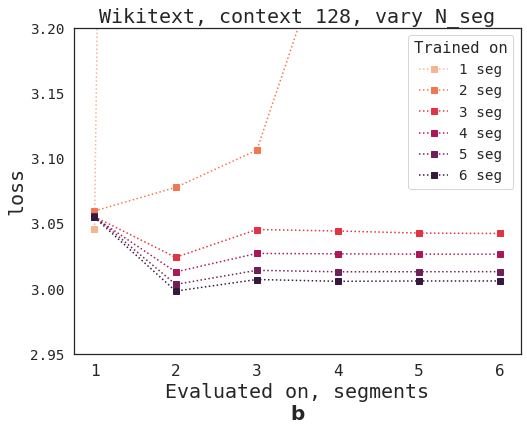

In [130]:
custom_palette = sns.color_palette("rocket_r", n_colors=table.shape[0])
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))

tab = table
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')]
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments\n'+r"$\bf{b}$", fontsize=fs)
plt.ylabel('loss', fontsize=fs)
plt.title('Wikitext, context 128, vary N_seg', fontsize=fs)

xt = eval_segments
plt.xticks(xt, labels=xt, fontsize=fs*0.8)
plt.ylim(2.95, 3.2)
models = [f'{i} seg' for i in list(tab.index)] + ['gpt2']
plt.legend(models, title='Trained on', loc='upper right')
plt.show()

### generalization

In [131]:
df = eval_df[eval_df.model_path.apply(lambda x: 'full' not in x)].copy()
gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segments']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segments'], values=['best_valid_loss'])
table.iloc[1:]

best_valid_loss                                          \
eval_segments                    1         2         3         4         5   
checkpoint_segment                                                           
1                         3.046113  7.804087  8.233383  8.166830  8.170070   
2                         3.077061  3.064014  3.102033  3.281115  3.417316   
3                         3.070558  3.081472  3.051880  3.049299  3.046972   
4                         3.069802  3.097854  3.041323  3.033479  3.032407   
5                         3.077610  3.095726  3.025278  3.014890  3.013975   
6                         3.079414  3.055293  3.018697  3.009377  3.008447   

                              
eval_segments              6  
checkpoint_segment            
1                   8.184538  
2                   3.413836  
3                   3.051105  
4                   3.032194  
5                   3.013873  
6                   3.008430

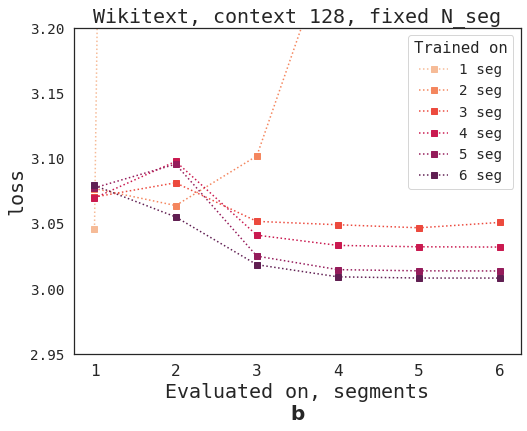

In [133]:
custom_palette = sns.color_palette("rocket_r", n_colors=table.shape[0])
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))

tab = table.iloc[1:]
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')]
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments\n'+r"$\bf{b}$", fontsize=fs)
plt.ylabel('loss', fontsize=fs)
plt.title('Wikitext, context 128, fixed N_seg', fontsize=fs)

xt = eval_segments
plt.xticks(xt, labels=xt, fontsize=fs*0.8)
plt.ylim(2.95, 3.2)
models = [f'{i} seg' for i in list(tab.index)] + ['gpt2']
plt.legend(models, title='Trained on', loc='upper right')
plt.show()

### curriculum


In [144]:
df = res_df[~res_df.checkpoint_segment.isna()]

In [145]:
gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'finetune_segments']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['finetune_segments'], values=['best_valid_loss'])
table.fillna('').iloc[2:]

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  This is separate from the ipykernel package so we can avoid doing imports until


best_valid_loss                                          \
finetune_segments               1         2         3         4         5    
checkpoint_segment                                                           
1                                   3.349814                                 
2                                             3.199924  3.015886  3.050146   
3                                                       3.032146             
4                                                                 3.013815   
5                                                                            
6                                                                            
8                                                                            

                                                               
finetune_segments         6         7         8  9         10  
checkpoint_segment                                             
1                                                              
2                                                              
3                                                              
4                   3.001824                                   
5                   3.008441            3.020231               
6                             2.997786  2.992996               
8                                                    2.990506

### lora

In [5]:
# res_df[res_df.init_from == 'RMT'].model_path.apply(lambda x: x.split('from_cpt')[1].split('/run')[0])
res_df.loc[(res_df.init_from == 'RMT') & (res_df.model_path.apply(lambda x: 'from_cpt_' in x)), 'init_from'] = 'curriculum'

In [6]:
df = res_df.copy()
df['lora'] = res_df.model_path.apply(lambda x: 'lora' in x)

metric_cols = ['best_valid_loss']
gb_cols = ['input_size', 'init_from', 'lora', 'num_mem_tokens', 'max_n_segments', 'lr']

df = df[metric_cols + gb_cols]
# df = df[(df.num_steps > 2000) & (df.num_mem_tokens.isin({1, 'NA'}))][metric_cols + gb_cols]

metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

group_df

best_valid_loss  \
input_size init_from  lora  num_mem_tokens max_n_segments lr                          
128        False      False 1.0            2              0.000050         4.526843   
                            2.0            1              0.000070         2.948220   
                                           2              0.000050         3.705454   
                            NA             1              0.000010         2.956689   
                                                          0.000050         2.951806   
                                                          0.000070         2.967653   
                      True  1.0            1              0.000010         3.235018   
                                                          0.000050         3.109142   
                                                          0.000100         3.081115   
                                                          0.000500         3.047585   
                                                          0.001000         3.047299   
                                                          0.005000         3.049052   
                                                          0.007000         3.051302   
                                                          0.010000         3.237536   
                                           2              0.000010         3.572092   
                                                          0.000050         3.135694   
                                                          0.000100         3.071933   
                                                          0.000500         2.993423   
                                                          0.005000         2.986088   
                                                          0.010000         3.016161   
                                                          0.050000         8.345038   
                                           3              0.000010         3.635913   
                                                          0.000050         3.293966   
                                                          0.000100         3.376936   
                                                          0.000500         3.047002   
                                                          0.001000         2.998755   
                                                          0.005000         3.031021   
                                           4              0.000500         3.108151   
                                                          0.001000         3.002783   
                                                          0.005000         3.145694   
                            2.0            1              0.001000         3.044026   
                                                          0.005000         3.044732   
                                           2              0.000500         3.907088   
                                                          0.001000         3.782183   
                                                          0.005000         4.758895   
                            5.0            1              0.000010         3.230953   
                                                          0.000050         3.110574   
                                           2              0.000010         3.771098   
                                                          0.000050         3.145579   
                                                          0.000500         3.920367   
                                                          0.001000         4.681130   
                                                          0.005000         6.260781   
                            NA             1              0.000010         3.248921   
                                                          0.000050         3.118121   
                                                          0.000100

In [43]:
df = res_df.copy()

metric_cols = ['best_valid_loss']
gb_cols = ['input_size', 'init_from', 'lora', 'num_mem_tokens', 'max_n_segments']

df = df[metric_cols + gb_cols]
# df = df[(df.num_steps > 2000) & (df.num_mem_tokens.isin({1, 'NA'}))][metric_cols + gb_cols]

metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

group_df

best_valid_loss  \
input_size init_from lora  num_mem_tokens max_n_segments                    
128        False     False 1.0            2                      4.526843   
                           2.0            1                      2.948220   
                                          2                      3.705454   
                           NA             1                      2.951806   
                     True  1.0            1                      3.047299   
                                          2                      2.986088   
                                          3                      3.293966   
                           2.0            1                      3.044026   
                                          2                      3.782183   
                           5.0            1                      3.110574   
                                          2                      3.145579   
                           NA             1                      3.053078   
           RMT       True  1.0            1                      2.945437   
                                          2                      2.878490   
                                          3                      2.882388   
           baseline  True  1.0            1                      2.951224   
                                          2                      3.464583   
                                          3                      2.942258   

                                                               std  n_runs  \
input_size init_from lora  num_mem_tokens max_n_segments                     
128        False     False 1.0            2                    NaN       1   
                           2.0            1               0.003205       3   
                                          2                    NaN       1   
                           NA             1               0.549918       4   
                     True  1.0            1               0.079591       9   
                                          2               1.981978       7   
                                          3               0.178363       3   
                           2.0            1               0.000500       2   
                                          2               0.613408       5   
                           5.0            1               0.085121       2   
                                          2               1.647942       3   
                           NA             1               0.296598      11   
           RMT       True  1.0            1               0.000283       2   
                                          2               1.981859       7   
                                          3               0.007212       5   
           baseline  True  1.0            1                    NaN       1   
                                          2                    NaN       1   
                                          3                    NaN       1   

                                                                                                       runs  
input_size init_from lora  num_mem_tokens max_n_segments                                                     
128        False     False 1.0            2                                                          [4.53]  
                           2.0            1                                              [2.95, 2.95, 2.95]  
                                          2                                                          [3.71]  
                           NA             1                                        [4.06, 2.95, 2.96, 2.97]  
                     True  1.0            1               [3.05, 3.05, 3.05, 3.05, 3.05, 3.08, 3.24, 3.2...  
                                          2                      [2.99, 3.02, 3.07, 3.57, 8.35, 2.99, 3.14]  
                                          3                                 

In [ ]:
res_df.model_ss

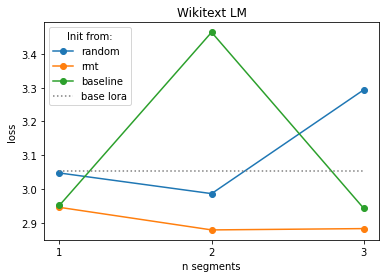

In [73]:
for init_from in (False, 'RMT', 'baseline'):
    slc = res_df[(res_df.init_from == init_from) & (res_df.model_path.apply(lambda x: 'lora' in x)) & (res_df.num_mem_tokens == 1)]
    metric_cols = ['best_valid_loss']
    gb_cols = ['input_size', 'init_from', 'lora', 'num_mem_tokens', 'max_n_segments']

    slc = slc[metric_cols + gb_cols]

    metric_cols = ['best_valid_loss']
    group_df = slc.groupby(gb_cols).min()[metric_cols]
    plt.plot(group_df.reset_index()['max_n_segments'].values, group_df[metric_cols[0]], marker='o')
    
base_lora_score = 3.053
plt.hlines(base_lora_score, 1, 3, linestyle='dotted', color='grey')


plt.xticks([1, 2, 3])
plt.legend(['random', 'rmt', 'baseline', 'base lora'], title='Init from:')

plt.title('Wikitext LM')
plt.xlabel('n segments')
plt.ylabel('loss')
plt.show()


selected

In [103]:
# df.groupby(gb_cols).count()

In [118]:
df = res_df[res_df.model_path.apply(lambda x: 'lora' in x)].copy()
df['lora'] = True

#add baseline
baseline_df = res_df[(res_df.num_mem_tokens.isin({'NA', 1})) & (res_df.input_seq_len.isin({128, 126, 252}))].copy()
# baseline_df = res_df[(res_df.num_mem_tokens.isin({'NA', 1})) & (res_df.input_seq_len.isin({128, 126}))].copy()
baseline_df.max_n_segments = baseline_df.max_n_segments.fillna(1)
baseline_df['lora'] = False
df = pd.concat((df, baseline_df))

df['from_finetuned'] = df.model_path.apply(lambda x: 'from_cpt' in x)
# df = df[(df.num_mem_tokens.isin({1, 'NA'})) & (df.lr == 5e-05) & (df.num_steps > 2000)]
df = df[(df.num_mem_tokens.isin({1, 'NA'})) & (df.lr.isin({5e-05, 5e-04})) & (df.num_steps > 2000)]

gb_cols = ['input_size', 'lora', 'from_finetuned', 'num_mem_tokens', 'max_n_segments', 'lr', 'num_steps']
metric_cols = ['best_valid_loss']
group_df = df[metric_cols + gb_cols] .groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

group_df

best_valid_loss  \
input_size lora  from_finetuned num_mem_tokens max_n_segments lr      num_steps                    
128        False False          1.0            1              0.00005 10000             2.947527   
                                               2              0.00005 10000             3.135694   
                                NA             1              0.00005 10000             2.953460   
                 True           1.0            1              0.00005 6000              2.945818   
                                                                      10000             2.945837   
                                               2              0.00005 6000              2.893435   
                                                                      10000             2.910222   
                                                              0.00050 10000             2.881192   
           True  False          1.0            1              0.00005 10000             3.109142   
                                               2              0.00005 10000             3.135694   
                                               3              0.00005 10000             3.293966   
                                NA             1              0.00005 10000             3.118121   
                 True           1.0            1              0.00005 10000             2.945837   
                                               2              0.00005 10000             2.910222   
                                                              0.00050 10000             2.881192   
                                               3              0.00050 10000             2.888766   

                                                                                      std  \
input_size lora  from_finetuned num_mem_tokens max_n_segments lr      num_steps             
128        False False          1.0            1              0.00005 10000      0.114279   
                                               2              0.00005 10000      0.751580   
                                NA             1              0.00005 10000      0.116433   
                 True           1.0            1              0.00005 6000       0.000150   
                                                                      10000           NaN   
                                               2              0.00005 6000       0.000000   
                                                                      10000      1.029753   
                                                              0.00050 10000           NaN   
           True  False          1.0            1              0.00005 10000           NaN   
                                               2              0.00005 10000           NaN   
                                               3              0.00005 10000           NaN   
                                NA             1              0.00005 10000           NaN   
                 True           1.0            1              0.00005 10000           NaN   
                                               2              0.00005 10000           NaN   
                                                              0.00050 10000           NaN   
                                               3              0.00050 10000           NaN   

                                                                                 n_runs  \
input_size lora  from_finetuned num_mem_tokens max_n_segments lr      num_steps           
128        False False          1.0            1              0.00005 10000           2   
                                               2              0.00005 10000           3   
                                NA             1              0.00005 10000           2   
                 True           1.0            1              0.00005 6000            4   
                                                           

In [128]:
# df = res_df[res_df.model_path.apply(lambda x: 'lora' in x)].copy()
# df['lora'] = True

# #add baseline
# baseline_df = res_df[(res_df.num_mem_tokens.isin({'NA', 1})) & (res_df.input_seq_len.isin({128, 126, 252}))].copy()
# # baseline_df = res_df[(res_df.num_mem_tokens.isin({'NA', 1})) & (res_df.input_seq_len.isin({128, 126}))].copy()
# baseline_df.max_n_segments = baseline_df.max_n_segments.fillna(1)
# baseline_df['lora'] = False
# df = pd.concat((df, baseline_df))

# df['from_finetuned'] = df.model_path.apply(lambda x: 'from_cpt' in x)
# # df = df[(df.num_mem_tokens.isin({1, 'NA'})) & (df.lr == 5e-05) & (df.num_steps > 2000)]
# df = df[(df.num_mem_tokens.isin({1, 'NA'})) & (df.num_steps > 2000)]

# gb_cols = ['input_size', 'lora', 'from_finetuned', 'num_mem_tokens', 'max_n_segments', 'lr', 'num_steps']
# metric_cols = ['best_valid_loss']
# group_df = df[metric_cols + gb_cols] .groupby(gb_cols).min()[metric_cols]
# group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
# group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
# group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

# group_df

### extrapolation

In [464]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and ('run_2' in x or 'mem10' in x))].copy()

Text(0, 0.5, 'Valid loss')

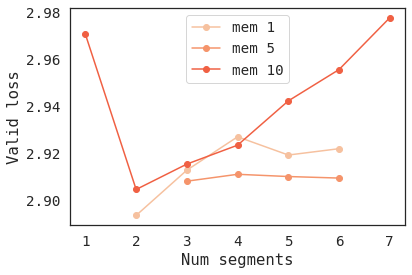

In [465]:
num_tokens = np.unique(df.num_mem_tokens)
for num_mem in num_tokens:
    slc = df[df.num_mem_tokens == num_mem]
    slc = slc[slc.checkpoint_segment == slc.eval_segment].sort_values('checkpoint_segment')
    plt.plot(slc.checkpoint_segment, slc.best_valid_loss, marker='o')
    
plt.legend([f'mem {int(n)}' for n in num_tokens])
plt.xlabel('Num segments')
plt.ylabel('Valid loss')

#### segmented validation mem 5

In [449]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and 'run_1' in x)].copy()
df = df[df.num_mem_tokens == 5]

gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

baseline_score = 2.953460
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table - baseline_score

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                         0.000786  5.240956  6.117512  6.284274  6.347375   
2                         0.092536 -0.056885  0.837013  1.908346  2.579189   
3                         0.114902  0.090783 -0.048290  0.000284  0.219169   
4                         0.160569  0.613973  0.078387 -0.041910  0.012016   
5                         0.183875  4.483671  2.112103  0.031773 -0.022282   
6                         0.183207  6.317534  2.233219  1.076151  0.047572   
7                         0.207037  7.519168  2.898285  3.155314  1.133836   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   6.367681  6.380861  6.386282  6.389956  6.391007  
2                   2.514880  2.503755  2.358686  2.285884  2.195533  
3                   0.753012  1.162861  1.475586  1.666424  1.782091  
4                   0.020721  0.024632  0.033421  0.037747  0.043806  
5                   0.035719  0.048383  0.049893  0.048087  0.047432  
6                  -0.021334  0.041760  0.062554  0.065884  0.066004  
7                   0.061890  0.000708  0.067672  0.089600  0.093359

#### segmented validation mem 10

In [450]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and 'run_1' in x)].copy()
df = df[df.num_mem_tokens == 10]

gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

baseline_score = 2.953460
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table - baseline_score 

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                         0.017031  5.316075  5.761672  5.850764  5.875190   
2                         0.223280 -0.049166  0.690764  1.837431  2.471289   
3                         0.660496  0.256801 -0.038329  0.064743  0.122927   
4                         0.771480  2.727141  0.241103 -0.030258  0.077450   
5                         0.652536  2.571806  2.459379  0.226902 -0.011359   
6                         0.619168  4.395004  4.443750  1.254856  0.189576   
7                         0.526521  4.862644  4.368672  2.254435  1.410561   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   5.885937  5.888419  5.888928  5.890251  5.889996  
2                   2.305344  2.553149  2.479140  2.543201  2.498211  
3                   0.414862  0.835361  1.150606  1.399120  1.564290  
4                   0.109023  0.152481  0.214284  0.286584  0.332159  
5                   0.095366  0.112459  0.134259  0.156879  0.166211  
6                   0.002016  0.092093  0.111999  0.116809  0.092531  
7                   0.170122  0.024124  0.107552  0.197584  0.216722

#### segmented validation run 2

In [377]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and 'run_1' in x)].copy()
seg1 = df[df.checkpoint_segment == 1].copy()
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and 'run_2' in x)].copy()
df = pd.concat((df, seg1))

In [378]:
# df = pd.concat(df, res_df

In [379]:
gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
# group_df

In [380]:
# table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
# table

In [381]:
baseline_score = 2.953460
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table - baseline_score 

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                        -0.008798  5.218863  5.758703  5.743047  5.707946   
2                         0.013564 -0.060241  0.020755  1.009615  1.278761   
3                         0.030341 -0.044586 -0.040917 -0.032559  0.088063   
4                         0.027879 -0.013891 -0.027874 -0.026687 -0.027281   
5                         0.031603 -0.032962 -0.032082 -0.034039 -0.034472   
6                         0.036607 -0.031358 -0.028739 -0.030962 -0.031641   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   5.691786  5.687142  5.684877  5.683396  5.682353  
2                   1.259507  1.319373  1.302102  1.322368  1.316135  
3                   0.139166  0.249414  0.329995  0.435976  0.523455  
4                  -0.027712 -0.027730 -0.027750 -0.027742 -0.027751  
5                  -0.034545 -0.034566 -0.034565 -0.034567 -0.034567  
6                  -0.031765 -0.031762 -0.031765 -0.031765 -0.031765

#### segmented validation run 1

In [383]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and 'run_1' in x)].copy()


In [384]:
gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
# group_df

In [387]:
# table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
# table

In [386]:
baseline_score = 2.953460
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table - baseline_score 

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                        -0.008798  5.218863  5.758703  5.743047  5.707946   
2                         0.012470 -0.061500  0.019545  1.009203  1.279158   
3                         0.019572 -0.038069 -0.033884 -0.010757  0.188753   
4                         0.025727 -0.025838 -0.026674 -0.025733 -0.026053   
5                         0.028103 -0.029862 -0.028878 -0.029711 -0.029498   
6                         0.028103 -0.029862 -0.028878 -0.029711 -0.029498   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   5.691786  5.687142  5.684877  5.683396  5.682353  
2                   1.260668  1.318112  1.301867  1.320214  1.313629  
3                   0.334932  0.477607  0.582409  0.685644       NaN  
4                  -0.026302 -0.026357 -0.026370 -0.026373       NaN  
5                  -0.029733 -0.029778 -0.029795       NaN       NaN  
6                  -0.029733 -0.029778 -0.029795       NaN       NaN

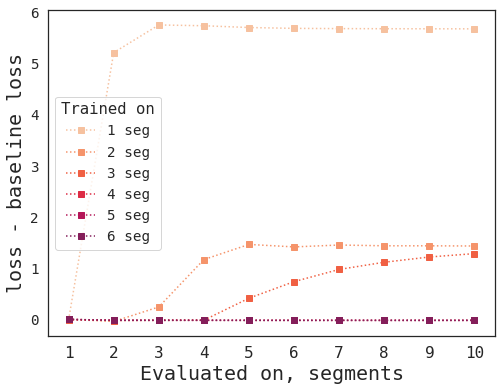

In [350]:
custom_palette = sns.color_palette("rocket_r", n_colors=8)
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


# tab = table[table.columns[:15]].iloc[:7]
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')] - baseline_score
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments', fontsize=fs)
plt.ylabel('loss - baseline loss', fontsize=fs)
plt.xticks(range(1, len(eval_segments)+1), labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
# plt.title('Memorization', fontsize=fs)

models = [f'{i} seg' for i in list(tab.index)]
plt.legend(models, title='Trained on')
# plt.savefig('img/extrapolate.pdf', format='pdf', bbox_inches='tight')
plt.show()

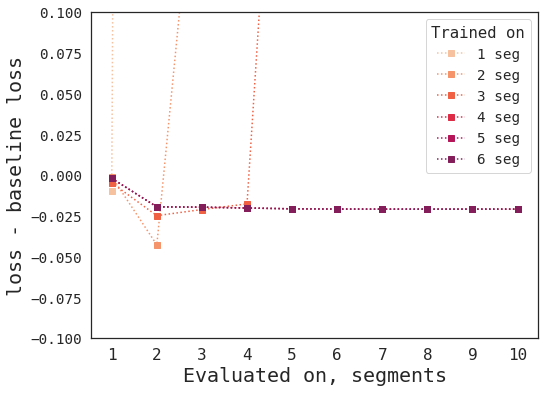

In [351]:
custom_palette = sns.color_palette("rocket_r", n_colors=8)
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


# tab = table[table.columns[:15]].iloc[:7]
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')] - baseline_score
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments', fontsize=fs)
plt.ylabel('loss - baseline loss', fontsize=fs)
plt.xticks(range(1, len(eval_segments)+1), labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
# plt.title('Memorization', fontsize=fs)
plt.ylim(-0.1, 0.1)

models = [f'{i} seg' for i in list(tab.index)]
plt.legend(models, title='Trained on')
# plt.savefig('img/extrapolate.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### continuous validation

In [276]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'chunked' in x)].copy()
df['checkpoint_segment'] = df.model_path.apply(lambda x: x.split('from_cpt_')[1].split('-')[0]).astype(int)
df['eval_segment'] = df.max_n_segments

In [277]:
gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
# group_df

In [278]:
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                         2.944067  8.172538  8.713217  8.698071  8.663234   
2                         2.952558  2.910761  3.194788  4.122667  4.418456   
3                         2.948757  2.928664  2.932415  2.935880  3.366055   
4                         2.951539  2.934062  2.933879  2.933349  2.932859   
5                         2.951539  2.934062  2.933879  2.933349  2.932859   
6                         2.951539  2.934062  2.933879  2.933349  2.932859   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   8.646637  8.642073  8.639933  8.638370  8.637287  
2                   4.370034  4.406917  4.391923  4.391372  4.387811  
3                   3.690738  3.929178  4.069761  4.172633  4.238768  
4                   2.932715  2.932674  2.932668  2.932667  2.932667  
5                   2.932715  2.932674  2.932668  2.932667  2.932667  
6                   2.932715  2.932674  2.932668  2.932667  2.932667

In [279]:
baseline_score = 2.953460
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table - baseline_score 

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                        -0.009393  5.219078  5.759757  5.744611  5.709774   
2                        -0.000902 -0.042699  0.241328  1.169207  1.464996   
3                        -0.004703 -0.024796 -0.021045 -0.017580  0.412595   
4                        -0.001921 -0.019398 -0.019581 -0.020111 -0.020601   
5                        -0.001921 -0.019398 -0.019581 -0.020111 -0.020601   
6                        -0.001921 -0.019398 -0.019581 -0.020111 -0.020601   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   5.693177  5.688613  5.686473  5.684910  5.683827  
2                   1.416574  1.453457  1.438463  1.437912  1.434351  
3                   0.737278  0.975718  1.116301  1.219173  1.285308  
4                  -0.020745 -0.020786 -0.020792 -0.020793 -0.020793  
5                  -0.020745 -0.020786 -0.020792 -0.020793 -0.020793  
6                  -0.020745 -0.020786 -0.020792 -0.020793 -0.020793

<Figure size 576x432 with 0 Axes>

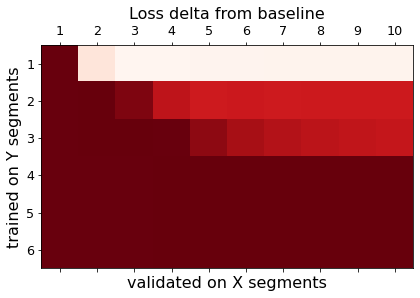

In [280]:
fs = 16
plt.figure(figsize=(8,6))
tab = table[table.columns[:15]].iloc[:7]
plt.matshow((table - baseline_score).values, cmap='Reds_r')
plt.xlabel('validated on X segments', fontsize=fs)
plt.ylabel('trained on Y segments', fontsize=fs)
plt.xticks(range(tab.shape[1]), labels=list(map(lambda x: x[1], tab.columns)), fontsize=fs*0.8)
plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('Loss delta from baseline', fontsize=fs)
# plt.savefig('img/extrapolate_hm.pdf', format='pdf')
plt.show()

### curriculum

In [182]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' not in x and 'from_cpt' in x)].copy()

In [183]:
df['chunked'] = df.model_path.apply(lambda x: 'chunked' in x)

In [184]:
gb_cols = ['input_size', 'max_n_segments', 'chunked', 'num_mem_tokens', 'lr', 'lr_scheduler',]
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_loss  \
input_size max_n_segments chunked num_mem_tokens lr      lr_scheduler                    
128        1              False   1.0            0.00005 linear               2.945818   
           2              False   1.0            0.00005 linear               4.366513   
                          True    1.0            0.00001 linear               4.395957   
           3              False   1.0            0.00005 linear               3.020203   
                          True    1.0            0.00001 linear               4.358905   
           4              False   1.0            0.00005 linear               2.997787   
                          True    1.0            0.00001 linear               2.954910   
           5              False   1.0            0.00005 linear               3.004885   
                          True    1.0            0.00001 linear               2.954769   
           6              False   1.0            0.00005 linear               3.004962   
                          True    1.0            0.00001 linear               2.954784   
           7              False   1.0            0.00005 linear               3.008343   
                          True    1.0            0.00001 linear               2.955649   
           8              False   1.0            0.00005 linear               3.008343   

                                                                            std  \
input_size max_n_segments chunked num_mem_tokens lr      lr_scheduler             
128        1              False   1.0            0.00005 linear        0.000173   
           2              False   1.0            0.00005 linear             NaN   
                          True    1.0            0.00001 linear             NaN   
           3              False   1.0            0.00005 linear             NaN   
                          True    1.0            0.00001 linear             NaN   
           4              False   1.0            0.00005 linear             NaN   
                          True    1.0            0.00001 linear             NaN   
           5              False   1.0            0.00005 linear        0.000000   
                          True    1.0            0.00001 linear             NaN   
           6              False   1.0            0.00005 linear             NaN   
                          True    1.0            0.00001 linear             NaN   
           7              False   1.0            0.00005 linear             NaN   
                          True    1.0            0.00001 linear             NaN   
           8              False   1.0            0.00005 linear             NaN   

                                                                       n_runs  \
input_size max_n_segments chunked num_mem_tokens lr      lr_scheduler           
128        1              False   1.0            0.00005 linear             3   
           2              False   1.0            0.00005 linear             1   
                          True    1.0            0.00001 linear             1   
           3              False   1.0            0.00005 linear             1   
                          True    1.0            0.00001 linear             1   
           4              False   1.0            0.00005 linear             1   
                          True    1.0            0.00001 linear             1   
           5              False   1.0            0.00005 linear             2   
                          True    1.0            0.00001 linear             1   
           6              False   1.0            0.00005 linear             1   
                          True    1.0            0.00001 linear             1   
           7              False   1.0            0.00005 linear             1   
                          True    1.0            0.00001 linear             1   
           8              False   1.0            0.00005 linear             1   

    

### vanilla

In [172]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' not in x and 'from_cpt' not in x)]

In [173]:
df = df[df.num_steps > 9000]

In [174]:
gb_cols = ['input_size', 'max_n_segments', 'num_mem_tokens', 'lr', 'lr_scheduler',]
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_loss  \
input_size max_n_segments num_mem_tokens lr      lr_scheduler                    
64         2              1.0            0.00005 linear               5.834481   
                          5.0            0.00005 linear               5.084059   
                          10.0           0.00005 linear               5.978330   
           3              1.0            0.00005 linear               3.196006   
                          5.0            0.00005 linear               3.258076   
                          10.0           0.00005 linear               3.344816   
           4              1.0            0.00005 linear               3.258616   
                          5.0            0.00005 linear               3.224445   
                          10.0           0.00005 linear               3.346584   
           5              1.0            0.00005 linear               3.255840   
                          5.0            0.00005 linear               3.324244   
128        1              1.0            0.00005 linear               2.947527   
                          5.0            0.00005 linear               2.960443   
                          10.0           0.00005 linear               2.976584   
                          NA             0.00005 linear               2.953460   
           2              1.0            0.00005 linear               4.380685   
                          5.0            0.00005 linear               3.526484   
                          10.0           0.00005 linear               4.289703   
           3              1.0            0.00005 linear               3.002402   
                          5.0            0.00005 linear               3.033959   
                          10.0           0.00005 linear               3.075089   
           4              1.0            0.00005 linear               3.016222   
                          5.0            0.00005 linear               3.031811   
                          10.0           0.00005 linear               3.038059   
           5              1.0            0.00005 linear               3.038116   
                          5.0            0.00005 linear               3.080352   
                          10.0           0.00005 linear               3.067651   
           6              1.0            0.00005 linear               3.020492   
256        1              1.0            0.00001 linear               2.825476   
                                         0.00005 linear               2.832754   
                                         0.00008 linear               2.841326   
                          5.0            0.00001 linear               2.833221   
                                         0.00005 linear               2.839976   
                                         0.00008 linear               2.849988   
                          10.0           0.00001 linear               2.839963   
                                         0.00005 linear               2.840628   
                                         0.00008 linear               2.852742   
                          NA             0.00001 linear               2.829825   
                                         0.00005 linear               2.836491   
           2              1.0            0.00001 linear               3.687324   
                                         0.00005 linear               3.688727   
                                         0.00008 linear               3.716200   
                          5.0            0.00001 linear               3.578869   
                                         0.00005 linear               3.601228   
                                         0.00008 linear               3.487755   
                          10.0           0.00001 linear               4.167626   
                                         0.00005 linear               3.826776   
                                         0.00

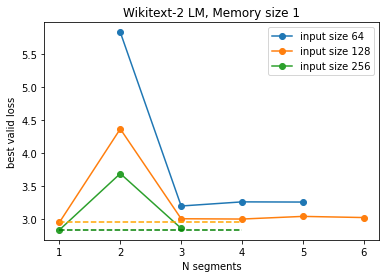

In [104]:
input_sizes = np.unique(df.input_size)
for input_size in input_sizes:
    mask = (df.input_size == input_size) & (df.lr ==0.00005) & (df.num_mem_tokens == 1)
    slc = df[mask]
    
    gb_cols = ['max_n_segments']

    group_df = slc.groupby(gb_cols).min()[metric_cols]
    
    plt.plot(group_df.index, group_df.values, marker='o')
    
plt.hlines(2.953460, 1, 4, linestyle='dashed', color='orange')
plt.hlines(2.836491, 1, 4, linestyle='dashed', color='green')

plt.title('Wikitext-2 LM, Memory size 1')
plt.xlabel('N segments')
plt.ylabel('best valid loss')
plt.legend([f'input size {s}' for s in input_sizes])
plt.xticks(np.unique(df.max_n_segments))
plt.show()

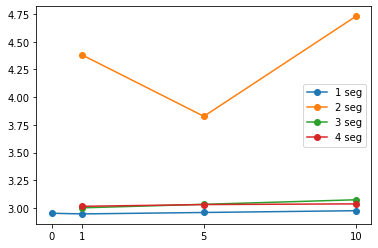

In [74]:
segment_sizes = np.unique(df.max_n_segments)
for n_seg in segment_sizes:
    mask = (df.input_size == 128) & (df.lr ==0.00005) & (df.max_n_segments == n_seg)
    slc = df[mask].copy()
    slc.loc[slc.num_mem_tokens == 'NA', 'num_mem_tokens'] = 0
    
    gb_cols = ['num_mem_tokens']

    group_df = slc.groupby(gb_cols).min()[metric_cols]
    
    plt.plot(group_df.index, group_df.values, marker='o')
    

# plt.title('Wikitext-2 LM, Memory size 1')
# plt.xlabel('N segments')
# plt.ylabel('best valid loss')
plt.legend([f'{s} seg' for s in segment_sizes])
plt.xticks([0, 1, 5, 10])
plt.show()

### wikitext

In [96]:
!cd ..;python parse_tb.py

  0%|          | 0/41 [00:00<?, ?it/s]
2023-04-06 12:34:16.453394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-06 12:34:16.453468: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [88]:
df = pd.read_csv('../results/wikitext.csv')

In [93]:
df.num_mem_tokens = df.num_mem_tokens.fillna('NA')
df.share_memory_layers = df.share_memory_layers.fillna(False)
df.k2 = df.k2.fillna(1)
df['from_cpt'] = (~df.backbone_cpt.isna()).fillna(False)
df.freeze_model_weights = df.freeze_model_weights.fillna(False)

In [94]:
df = df[df.best_valid_loss < 3]

In [95]:
gb_cols = ['from_pretrained', 'model_cls', 'num_mem_tokens', 'lr', 'lr_scheduler', 'k2', 'freeze_model_weights', 'from_cpt']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_loss  \
from_pretrained model_cls                                          num_mem_tokens lr       lr_scheduler         k2   freeze_model_weights from_cpt                    
gpt2            modeling_rmt.language_modeling:RMTDecoderLMHead    10.0           0.000005 linear                1.0 False                False            2.696082   
                                                                   25.0           0.000005 constant_with_warmup  1.0 False                False            2.693921   
                                                                                                                 2.0 False                False            2.693101   
                                                                                           linear                1.0 False                False            2.700119   
                                                                                                                 2.0 False                False            2.697857   
                modeling_rmt.language_modeling:RMTDecoderMemory... 10.0           0.000001 linear                1.0 False                False            2.857818   
                                                                                                                 2.0 False                False            2.839722   
                                                                                  0.000005 linear                1.0 False                False            2.724896   
                                                                                                                 2.0 False                False            2.709527   
                                                                                  0.000010 constant_with_warmup  1.0 True                 True             2.764399   
                                                                                           linear                1.0 False                False            2.698679   
                                                                                                                                          True             2.695399   
                                                                                                                 2.0 False                False            2.684810   
                                                                                  0.000100 constant_with_warmup  1.0 True                 True             2.783597   
                modeling_rmt:RMTDecoderForCausalLM                 10.0           0.000005 constant_with_warmup  1.0 False                False            2.692568   
                                                                                                                 2.0 False                False            2.688242   
                                                                                                                 3.0 False                False            2.688129   
                                                                                  0.000010 constant_with_warmup  1.0 False                False            2.696101   
                                                                                           linear                1.0 False                False            2.707594   
                                                                                  0.000050 constant_with_warmup  1.0 False                False            2.706325   
                                                                                  0.000100 constant_with_warmup  1.0 False                False            2.719023   
                                                                   25.0           0.000010 linear                1.0 False                False            2.833547   
                                                                   50.0           0.000005 constant_with_warmup  1.0 False                Fa

### qmsum

In [348]:
!cd ..;python parse_tb.py

  0%|          | 0/1913 [00:00<?, ?it/s]


In [19]:
# res_df = pd.read_csv('../results/qmsum.csv')

In [ ]:
res_df.input_seg_size = res_df.input_seg_size.fillna(512)
res_df = res_df[res_df.num_steps.isin({3200})]
res_df.fillna('UNKNOWN', inplace=True)

In [ ]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss', 'segment_ordering']
metric_cols = ['best_valid_rouge/geometric_mean']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = res_df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = res_df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

In [37]:
# group_df.sort_values('best_valid_rouge/geometric_mean')

### quality

In [603]:
!cd ..;python parse_tb.py

  0%|          | 0/1630 [00:00<?, ?it/s]


In [45]:
# res_df = pd.read_csv('../results/quality.csv')
paths = [
        '../results/quality.csv',
        '../results/quality_new.csv'
        ]
         

In [46]:
res_df = pd.concat([pd.read_csv(p) for p in paths])
res_df.input_seg_size = res_df.input_seg_size.fillna(512)
# res_df.padding_side = res_df.padding_side.fillna('left')
# res_df = res_df[res_df.num_steps.isin({3200})]
res_df.fillna('UNKNOWN', inplace=True)
res_df = res_df[res_df.num_steps.isin({'UNKNOWN', 3200, 1600})]

In [47]:
# res_df = res_df[res_df.best_valid_exact_match > 1]

In [48]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss', 'segment_ordering' ]
metric_cols = ['best_valid_exact_match']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[['best_valid_exact_match']]
group_df['n_runs'] = res_df.groupby(gb_cols).count()['best_valid_exact_match']
group_df['runs'] = res_df.groupby(gb_cols).agg({'best_valid_exact_match':tuple}).best_valid_exact_match.apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_exact_match  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering                           
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                        31.208099   
                               984           25.0           0.00020 linear       True     bidirectional                  21.524450   
                                                                                          regular                         0.000000   
                               998           10.0           0.00005 linear       UNKNOWN  UNKNOWN                        28.395667   
                                                            0.00010 linear       UNKNOWN  UNKNOWN                        30.021550   
                               1002          10.0           0.00020 linear       False    regular                         0.023950   
                                                                                          repeat_first                   28.799150   
                                                                                 True     bidirectional                  28.811151   
                               1024          UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                        32.454498   
                               1503          10.0           0.00020 linear       True     bidirectional                  24.017300   
                                                                                          regular                         0.000000   
                                                                                          repeat_first                   27.468800   

                                                                                                                 std  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering             
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                NaN   
                               984           25.0           0.00020 linear       True     bidirectional     1.559242   
                                                                                          regular           0.000000   
                               998           10.0           0.00005 linear       UNKNOWN  UNKNOWN           0.508137   
                                                            0.00010 linear       UNKNOWN  UNKNOWN           0.167795   
                               1002          10.0           0.00020 linear       False    regular           0.026236   
                                                                                          repeat_first      0.638873   
                                                                                 True     bidirectional     0.813526   
                               1024          UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                NaN   
                               1503          10.0           0.00020 linear       True     bidirectional          NaN   
                                                                                          regular           0.000000   
                                                                                          repeat_first           NaN   

                                                                                                            n_runs  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering           
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                1   
                               984           25.0           0.00020 linear       True     bidirectional          2   
                                                                              